In [1]:
import json

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import ipywidgets

from stellarpunk import util

# Loading and Preparing Data

In [2]:
df_base = pd.read_json("/tmp/stellarpunk.history.gz", lines=True)
df_base = df_base.join(pd.json_normalize(df_base["o"]).add_prefix("o."))

In [3]:
eids = pd.Series(df_base["eid"].unique())
eids

0      14b985e3-9d0d-4742-a901-ceda9045d4a9
1      3a7e873f-4677-4d00-95ca-7e87285cefbe
2      92e2b85d-dee2-4a92-9426-1dc0821ea109
3      7ae3edb0-6904-4462-b85e-82e5d995a4f9
4      e791c96e-4613-4f31-b0f3-35203a000edf
                       ...                 
124    45f8eca8-ba6b-449e-9bfe-402100b3627a
125    922e3718-1d71-4c70-ba8f-e7a5085336a9
126    2493553e-a02d-41b0-ae78-8135bf319d17
127    e30bb911-9a97-42ad-9717-f62a44d0d7bc
128    ed0c3d1a-2a30-46fb-b8a3-421d050d8cd4
Length: 129, dtype: object

In [4]:
targets = eids[pd.Series(df_base["eid"].unique()).str.startswith("920")]
targets

99    92012b07-e5be-4a7e-bda2-602968a1ea21
dtype: object

In [5]:
target_index = targets.index[0]

In [6]:
target_eid = df_base["eid"].unique()[target_index]
df_base = df_base[df_base["eid"] == target_eid].reset_index()
df_base["eid"].unique()

array(['92012b07-e5be-4a7e-bda2-602968a1ea21'], dtype=object)

In [7]:
loc = pd.DataFrame(np.vstack(df_base["loc"]), columns=["loc.x", "loc.y"])
v = pd.DataFrame(np.vstack(df_base["v"]), columns=["v.x", "v.y"])

empty_array = np.empty(len(df_base))
empty_array[:] = np.nan

if "o.t_loc" in df_base:
    o_tloc = pd.DataFrame(np.vstack(df_base["o.t_loc"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), columns=["o.t_loc.x", "o.t_loc.y"])
    o_tv = pd.DataFrame(np.vstack(df_base["o.t_v"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), columns=["o.t_v.x", "o.t_v.y"])
else:
    o_tloc = pd.DataFrame({"o.t_loc": empty_array, "o.t_loc.x": empty_array, "o.t_loc.y": empty_array})
    o_tv = pd.DataFrame({"o.t_v": empty_array, "o.t_v.x": empty_array, "o.t_v.y": empty_array})
    
if "o.ct" in df_base:
    o_ctloc = pd.DataFrame(np.vstack(df_base["o.ct_loc"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), columns=["o.ct_loc.x", "o.ct_loc.y"])
    o_ctdv = pd.DataFrame(np.vstack(df_base["o.ct_dv"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), columns=["o.ct_dv.x", "o.ct_dv.y"])
    o_ctv = pd.DataFrame(np.vstack(df_base["o.ct_v"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), columns=["o.ct_v.x", "o.ct_v.y"])
    o_ctcloc = pd.DataFrame(np.vstack(df_base["o.ct_cloc"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), columns=["o.ct_cloc.x", "o.ct_cloc.y"])
else:
    o_ctloc = pd.DataFrame({"o.ct_loc": empty_array, "o.ct_loc.x": empty_array, "o.ct_loc.y": empty_array})
    o_ctdv = pd.DataFrame({"o.ct_dv": empty_array, "o.ct_dv.x": empty_array, "o.ct_dv.y": empty_array})
    o_ctv = pd.DataFrame({"o.ct_v": empty_array, "o.ct_v.x": empty_array, "o.ct_v.y": empty_array})
    o_ctcloc = pd.DataFrame({"o.ct_cloc": empty_array, "o.ct_cloc.x": empty_array, "o.ct_cloc.y": empty_array})
angle = pd.DataFrame(np.vstack(df_base.apply(lambda row: np.array(util.polar_to_cartesian(100, row["a"])), axis=1)), columns=["angle.x", "angle.y"])
desired_angle = pd.DataFrame(np.vstack(df_base.apply(lambda row: np.array(util.polar_to_cartesian(100, row["o._ada"])), axis=1)), columns=["_ada.x", "_ada.y"])
df = pd.concat([df_base, loc, v, o_ctloc, o_ctcloc, o_ctdv, o_ctv, o_tloc, o_tv, angle, desired_angle], axis=1)

if "o.ct" not in df_base:
    df["o.ct"] = empty_array
    df["o.ct_ts"] = empty_array
    df["o.cac"] = empty_array
    df["o.cbdr"] = empty_array
    df["o.cbdr_hist"] = empty_array
    df["o.ct_ct"] = empty_array
    df["o.ct_cradius"] = empty_array
    df["o.nd"] = empty_array
    df["o.ct_dist"] = empty_array
else:
    df["o.ct_dist"] = np.linalg.norm(np.vstack(df["loc"]) - np.vstack(df["o.ct_cloc"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), axis=1)
    
if "o.t_loc" not in df_base:
    df["o.cs"] = empty_array
    df["o.t_dist"] = empty_array
else:
    df["o.t_dist"] = np.linalg.norm(np.vstack(df["loc"]) - np.vstack(df["o.t_loc"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), axis=1)

In [8]:
df["speed"] = np.linalg.norm(df[["v.x", "v.y"]], axis=1)
df["o.t_speed"] = np.linalg.norm(df[["o.t_v.x", "o.t_v.y"]], axis=1)
df["f_mag"] = df["f"].apply(lambda x:np.linalg.norm(x))

In [9]:
#df["o.ct_v.x"] = (df["o.ct_loc.x"].shift(1) - df["o.ct_loc.x"]) / (df["ts"].shift(1) - df["ts"])
#df["o.ct_v.y"] = (df["o.ct_loc.y"].shift(1) - df["o.ct_loc.y"]) / (df["ts"].shift(1) - df["ts"])

In [10]:
df

,index,p,eid,ts,loc,r,a,v,av,f,...,o.t_v.y,angle.x,angle.y,_ada.x,_ada.y,o.ct_dist,o.t_dist,speed,o.t_speed,f_mag
0,10995,SHP,92012b07-e5be-4a7e-bda2-602968a1ea21,160.383333,"[-59033.15217183964, 41109.70008730623]",30,-11.809252,"[194.71952697681502, 184.38456259957442]",0.000000,"[145222.76716729498, 137514.90063361728]",...,600.532051,72.681802,68.683009,72.611384,68.757450,NaN,160079.075171,268.166667,873.406516,200000.0
1,10996,SHP,92012b07-e5be-4a7e-bda2-602968a1ea21,160.550000,"[-58999.79127504871, 41141.29031586845]",30,-11.809252,"[206.82142424075636, 195.8441376523758]",0.000000,"[145222.76716729495, 137514.9006336173]",...,612.478782,72.681802,68.683009,72.611384,68.757450,NaN,160033.130727,284.833333,890.781695,200000.0
2,10997,SHP,92012b07-e5be-4a7e-bda2-602968a1ea21,160.716667,"[-58964.413395380456, 41174.79047360614]",30,-11.809252,"[218.9233215046977, 207.30371270517716]",0.000000,"[145222.76716729495, 137514.9006336173]",...,621.213961,72.681802,68.683009,72.611384,68.757450,NaN,159984.408504,301.500000,903.486033,200000.0
3,10998,SHP,92012b07-e5be-4a7e-bda2-602968a1ea21,160.883333,"[-58927.018532834874, 41210.2005605193]",30,-11.809252,"[231.02521876863904, 218.76328775797853]",0.000000,"[145222.7671672949, 137514.90063361736]",...,633.041448,72.681802,68.683009,72.611384,68.757450,NaN,159932.908504,318.166667,920.687787,200000.0
4,10999,SHP,92012b07-e5be-4a7e-bda2-602968a1ea21,161.050000,"[-58887.60668741197, 41247.52057660792]",30,-11.809252,"[243.12711603258037, 230.2228628107799]",0.000000,"[145222.76716729486, 137514.90063361736]",...,645.919977,72.681802,68.683009,72.611384,68.757450,NaN,159878.630727,334.833333,939.418163,200000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3596,14591,SHP,92012b07-e5be-4a7e-bda2-602968a1ea21,761.997334,"[23866.455387268445, 123912.80442617422]",30,29.929858,"[-1561.2890196561043, -1785.463221895414]",-0.708857,"[-1678.3417701332776, -199992.95779827505]",...,-876.808564,8.462670,-99.641273,-0.839171,-99.996479,1384.059231,108941.039839,2371.814141,1104.093478,200000.0
3597,14592,SHP,92012b07-e5be-4a7e-bda2-602968a1ea21,762.164001,"[23606.2250679377, 123613.97732337768]",30,29.840613,"[-1561.5243115625954, -1802.1281593983272]",-0.296919,"[-3285.5827347548884, -199973.01054415587]",...,-589.034551,-0.451711,-99.998980,-1.642791,-99.986505,990.278593,108545.581279,2384.538546,741.592175,200000.0
3598,14593,SHP,92012b07-e5be-4a7e-bda2-602968a1ea21,762.330668,"[23345.955315627933, 123312.37274083907]",30,29.828627,"[-1561.655569539314, -1818.793828736793]",0.203081,"[2639.4958364876, -199982.58189584705]",...,-300.258153,-1.650294,-99.986382,1.319748,-99.991291,593.570860,108147.898107,2397.244065,377.961047,200000.0
3599,14594,SHP,92012b07-e5be-4a7e-bda2-602968a1ea21,762.497334,"[23085.731824330294, 123007.99212530658]",30,29.899973,"[-1560.395337172975, -1835.3872692402394]",0.703081,"[3801.9920761665608, -14510.163894758967]",...,-79.453877,5.481558,-99.849650,25.346614,-96.734426,194.242316,107748.042486,2409.041311,100.000000,15000.0


In [11]:
df.iloc[-1]["o"]

{'o': 'stellarpunk.orders.movement.GoToLocation',
 'ct': '922e3718-1d71-4c70-ba8f-e7a5085336a9',
 'ct_ms': 52.906181399503254,
 'ct_loc': [22936.653559194816, 122857.8901834445],
 'ct_v': [-608.91281889222, -41.838288162263595],
 'ct_ts': 758.2473344342354,
 'ct_dv': [2554.866934431847, 1572.4677889695597],
 'ct_tc': 0.0,
 'ct_ct': 1,
 'ct_cloc': [22936.653559194816, 122857.8901834445],
 'ct_cradius': 30.0,
 'ct_cn': [[22936.653559194816, 122857.8901834445]],
 'ct_dv_override': False,
 'cac': False,
 'cach': True,
 'cbdr': False,
 'cbdr_hist': [[-10481.50500071497, -11175.952997328277],
  [-45.05608449488136, -27.73108869603311]],
 'nd': 7.957747154594767e-09,
 'nnd': 52.906181399503254,
 '_nact': 0.0,
 '_ada': 0.5517236781870241,
 't_loc': [-42340.32625802903, 37397.995142639826],
 'ad': 4500.0,
 'md': 0.0,
 't_v': [-60.71518008020584, -79.45858611772661],
 'cs': False,
 'scm': 90.09121072097417,
 '_ncts': 762.6330487199458,
 '_dv': [2476.161796442754, 669.1746068988617]}

# Basic Ship Vitals

## Position and Heading

In [12]:
def plot_location_chart(max_time):
    sample = df[df["ts"] <= max_time].iloc[::50]
    plt.quiver(sample["loc.x"], sample["loc.y"], sample["angle.x"], sample["angle.y"])#, scale=100)
    plt.scatter(sample["o.t_loc.x"], sample["o.t_loc.y"])
    #center = (0,2500)
    #radius = 10000
    #plt.xlim(center[0]-radius,center[0]+radius)
    #plt.ylim(center[1]-radius,center[1]+radius)

ipywidgets.interact(plot_location_chart, max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max(), continuous_update=False))

interactive(children=(FloatSlider(value=762.5640011008982, continuous_update=False, description='max_time', ma…

<function __main__.plot_location_chart(max_time)>

In [13]:
df[["loc.x", "loc.y"]].describe()

,loc.x,loc.y
count,3601.000000,3601.000000
mean,-12586.580933,90843.156258
std,53819.788132,52424.617253
min,-89133.290003,18300.242902
25%,-67513.504476,37823.819203
50%,-4726.186157,97879.025559
75%,42808.596884,144807.355098
max,54553.062462,156984.708115


Text(0.5, 1.0, 'position')

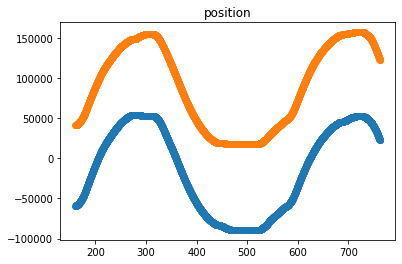

In [14]:
plt.scatter(df["ts"], df["loc.x"])
plt.scatter(df["ts"], df["loc.y"])
plt.title("position")

In [15]:
def plot_heading(hist_length, max_time):
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)]
    plt.scatter(sample["ts"], sample["a"].apply(lambda x: util.normalize_angle(x, shortest=True)), label="theta")
    plt.scatter(sample["ts"], sample["av"], label="omega")
    plt.scatter(sample["ts"], sample["o._ada"].apply(lambda x: util.normalize_angle(x, shortest=True)), label="desired theta")
    plt.hlines(np.pi, sample["ts"].min(), sample["ts"].max(), color="red")
    plt.hlines(0, sample["ts"].min(), sample["ts"].max(), color="red")
    plt.legend()
    plt.title("heading and angular velocity")
    
ipywidgets.interact(plot_heading, hist_length=ipywidgets.FloatSlider(value=15, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False), max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+.1, continuous_update=False))

interactive(children=(FloatSlider(value=15.0, continuous_update=False, description='hist_length', max=602.1806…

<function __main__.plot_heading(hist_length, max_time)>

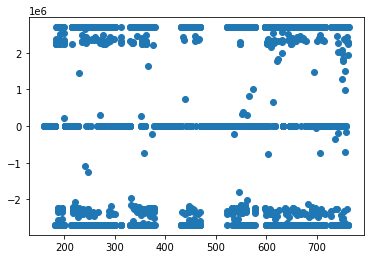

In [16]:
plt.scatter(df["ts"], df["t"])

In [17]:
(df["t"] == 0).value_counts()

False    2003
True     1598
Name: t, dtype: int64

## Velocity and Acceleration

In [18]:
def plot_speed(hist_length, max_time):
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)]
    plt.scatter(sample["ts"], sample["speed"])
    plt.title("speed")
    print(f'min speed: {sample["speed"].min()}')
    print(f'max speed: {sample["speed"].max()}')
    
ipywidgets.interact(plot_speed, hist_length=ipywidgets.FloatSlider(value=15, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False), max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+.1, continuous_update=False))

interactive(children=(FloatSlider(value=15.0, continuous_update=False, description='hist_length', max=602.1806…

<function __main__.plot_speed(hist_length, max_time)>

In [19]:
def plot_velocity(hist_length, max_time):
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)]
    plt.scatter(sample["ts"], sample["v.x"], label="x")
    plt.scatter(sample["ts"], sample["v.y"], label="y")
    plt.legend()
    plt.title("velocity")
    
ipywidgets.interact(plot_velocity, hist_length=ipywidgets.FloatSlider(value=15, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False), max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+.1, continuous_update=False))

interactive(children=(FloatSlider(value=15.0, continuous_update=False, description='hist_length', max=602.1806…

<function __main__.plot_velocity(hist_length, max_time)>

In [20]:
def plot_acceleration(hist_length, max_time):
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)]
    plt.scatter(sample["ts"], (sample["v.x"].shift(1) - sample["v.x"]) / (sample["ts"].shift(1) - sample["ts"]), label="x")
    plt.scatter(sample["ts"], (sample["v.y"].shift(1) - sample["v.y"]) / (sample["ts"].shift(1) - sample["ts"]), label="y")
    plt.yscale("symlog")
    plt.legend()
    plt.title("acceleration")
    
ipywidgets.interact(plot_acceleration, hist_length=ipywidgets.FloatSlider(value=15, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False), max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+.1, continuous_update=False))

interactive(children=(FloatSlider(value=15.0, continuous_update=False, description='hist_length', max=602.1806…

<function __main__.plot_acceleration(hist_length, max_time)>

In [21]:
def plot_force(hist_length, max_time):
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)]
    plt.scatter(sample["ts"], sample["f_mag"])
    plt.yscale("log")
    plt.title("force")
    print(f'min force={sample["f_mag"].min()}')
    print(f'max force={sample["f_mag"].max()}')

ipywidgets.interact(plot_force, hist_length=ipywidgets.FloatSlider(value=15, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False), max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+.1, continuous_update=False))

interactive(children=(FloatSlider(value=15.0, continuous_update=False, description='hist_length', max=602.1806…

<function __main__.plot_force(hist_length, max_time)>

# Behavior Monitoring

In [22]:
[next((df.iloc[idx]["ts"] if idx is not None else None for idx, v in zip(df.index, (~df[c].isna() & df[c] == True)) if v), None) for c in ["o.ct", "o.cs", "o.cac", "o.cbdr"]]

[277.71666666674275, None, 337.0000666666888, 548.6667333331629]

In [23]:
def plot_collision_info(hist_length, max_time):
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)]
    plt.scatter(sample["ts"], (~(sample["o.ct"].isna())).astype(int), label="ct")
    plt.scatter(sample["ts"], sample["o.cs"].fillna(0).astype(int)+0.05, label="cs")
    plt.scatter(sample["ts"], sample["o.cac"].fillna(0).astype(int)+0.1, label="cac")
    plt.scatter(sample["ts"], sample["o.cbdr"].fillna(0).astype(int)+0.15, label="cbdr")
    plt.scatter(sample["ts"], sample["o.cach"].fillna(0).astype(int)+0.1, label="cach", marker="+")
    plt.scatter(sample["ts"], sample["o.ct_dv_override"].fillna(0).astype(int)+0.2, label="dv override")
    plt.legend()
    plt.title("status flags")
    
    flag_cols = ["o.ct", "o.cs", "o.cac", "o.cach", "o.cbdr", "o.ct_dv_override"]
    first_ts = [
        next(
            (sample.loc[idx]["ts"] if idx is not None else None
             for idx, v in zip(sample.index, (~sample[c].isna() & sample[c] == True))
             if v),
            None
        )
        for c in flag_cols
    ]
    for c, ts in zip(flag_cols, first_ts):
        print(f'first {c}: {ts}')

ipywidgets.interact(plot_collision_info, hist_length=ipywidgets.FloatSlider(value=15, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False), max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+.1, continuous_update=False))

interactive(children=(FloatSlider(value=15.0, continuous_update=False, description='hist_length', max=602.1806…

<function __main__.plot_collision_info(hist_length, max_time)>

### Target Location

In [24]:
if np.any(~df["o.t_loc"].isna()):
    x = df.groupby(["o.t_loc.x", "o.t_loc.y"]).agg({"ts": ["count", "min", "max"], "o.t_dist": ["min","max"], "o.ad":["min"]})
else:
    x = "no location target"
x

ts                               o.t_dist  \
                            count         min         max            min   
o.t_loc.x     o.t_loc.y                                                    
-89528.073776 18275.943649    151  445.166733  470.166733     396.335424   
-86042.144550 16221.591997    800  311.833400  445.000067    3420.181809   
-42340.326258 37397.995143    203  727.590276  762.564001  107587.650758   
 48346.070301 156660.189513   999  522.166733  688.500067    3539.713984   
 52658.332785 157141.274214   171  688.666733  717.000067     393.672663   
 52661.928154 155029.063904   154  275.383333  301.333400     442.620640   
 57202.479138 151175.990666   690  160.383333  275.216667    3649.446725   

                                              o.ad  
                                       max     min  
o.t_loc.x     o.t_loc.y                             
-89528.073776 18275.943649     5915.562701   500.0  
-86042.144550 16221.591997   196019.797945  4500.0  
-42340.326258 37397.995143   152503.159487  4500.0  
 48346.070301 156660.189513  195048.817501  4500.0  
 52658.332785 157141.274214    7450.419231   500.0  
 52661.928154 155029.063904    6636.999839   500.0  
 57202.479138 151175.990666  160079.075171  4500.0

In [25]:
#sample = df[(df["ts"] < 124.4) & (df["ts"] > 120)]
def plot_target_distance(hist_length, max_time):
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)]
    plt.scatter(sample["ts"], sample["o.t_dist"])
    plt.scatter(sample["ts"], sample["o.ad"], color="green", marker="_")
    plt.scatter(sample["ts"], sample["o.md"], color="red", marker="_")
    #plt.ylim(0,1500)
    plt.title("distance to target")
    print(f'when first arrived {sample[sample["o.t_dist"] < sample["o.ad"]]["ts"].min()}')

ipywidgets.interact(
    plot_target_distance,
    hist_length=ipywidgets.FloatSlider(value=15, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False),
    max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+.1, continuous_update=False))

interactive(children=(FloatSlider(value=15.0, continuous_update=False, description='hist_length', max=602.1806…

<function __main__.plot_target_distance(hist_length, max_time)>

In [26]:
df[df["o.t_dist"] < df["o.ad"]]["ts"].min()

271.21666666674867

In [27]:
def plot_desired_speed(hist_length, max_time):
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)]
    plt.scatter(sample["ts"], sample["speed"], label="actual speed")
    plt.scatter(sample["ts"], sample["o.t_speed"], label="desired speed")
    plt.legend()
    plt.title("speed and desired speed to target")
    plt.ylim(0)

ipywidgets.interact(
    plot_desired_speed,
    hist_length=ipywidgets.FloatSlider(value=15, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False),
    max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+.1, continuous_update=False))

interactive(children=(FloatSlider(value=15.0, continuous_update=False, description='hist_length', max=602.1806…

<function __main__.plot_desired_speed(hist_length, max_time)>

Text(0.5, 1.0, 'desired speed delta')

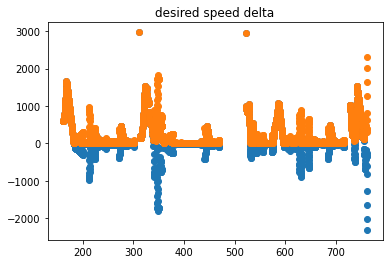

In [28]:
plt.scatter(df["ts"], df["o.t_speed"] - df["speed"])
plt.scatter(df["ts"], np.linalg.norm(np.array((df["o.t_v.x"] - df["v.x"], df["o.t_v.y"] - df["v.y"])), axis=0))
plt.title("desired speed delta")

## Collision Avoidance

### Collision Threats

In [29]:
def show_collision_threats(hist_length, max_time):
    sample = df[(df["ts"] >= max_time-hist_length) & (df["ts"] <= max_time)]
    if np.any(~sample["o.ct"].isna()):
        x = sample.groupby("o.ct").agg({"ts": ["count", "min", "max"], "o.ct_dist": ["min","max"]})
    else:
        x = "no collision threats"
    return x
ipywidgets.interact(
    show_collision_threats,
    hist_length=ipywidgets.FloatSlider(value=15, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False),
    max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+.1, continuous_update=False)
)

interactive(children=(FloatSlider(value=15.0, continuous_update=False, description='hist_length', max=602.1806…

<function __main__.show_collision_threats(hist_length, max_time)>

In [30]:
def plot_collision_distance(hist_length, max_time):
    sample = df[(df["ts"] >= max_time-hist_length) & (df["ts"] <= max_time)]
    plt.scatter(sample["ts"], sample["o.ct_dist"])
    plt.scatter(sample["ts"], sample["o.ct_cradius"]+sample["o.scm"]*2, color="green", marker="_")
    plt.scatter(sample["ts"], sample["o.ct_cradius"]+sample["o.scm"], color="orange", marker="_")
    plt.scatter(sample["ts"], sample["o.ct_cradius"], color="red", marker="_")
    plt.hlines(60, sample["ts"].min(), sample["ts"].max(), color="red")
    plt.ylim(0)
    plt.title("distance to collision threat")
    print(f'max ct dist: {sample["o.ct_dist"].max()}')
    print(f'min ct dist: {sample["o.ct_dist"].min()}')

ipywidgets.interact(
    plot_collision_distance,
    hist_length=ipywidgets.FloatSlider(value=15, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False),
    max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+.1, continuous_update=False)
)

interactive(children=(FloatSlider(value=15.0, continuous_update=False, description='hist_length', max=602.1806…

<function __main__.plot_collision_distance(hist_length, max_time)>

In [31]:
def plot_minimum_separation(hist_length, max_time):
    sample = df[(df["ts"] >= max_time-hist_length) & (df["ts"] <= max_time)]
    plt.scatter(sample["ts"], sample["o.ct_ms"])
    #plt.scatter(sample["ts"], sample["o.ct_cradius"]+30, color="red", marker="_")
    plt.ylim(0)
    plt.title("minimum_separation with collision threat")
    print(f'max min sep: {sample["o.ct_ms"].max()}')
    print(f'min min sep: {sample["o.ct_ms"].min()}')

ipywidgets.interact(
    plot_minimum_separation,
    hist_length=ipywidgets.FloatSlider(value=15, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False),
    max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+.1, continuous_update=False)
)

interactive(children=(FloatSlider(value=15.0, continuous_update=False, description='hist_length', max=602.1806…

<function __main__.plot_minimum_separation(hist_length, max_time)>

In [32]:
def plot_threat_age(hist_length, max_time):
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)]
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    ax1.scatter(sample["ts"], 1-sample["o.ct"].isna().astype(int))
    ax2.scatter(sample["ts"], sample["ts"] - sample["o.ct_ts"], color="orange")
    plt.title("Collision Threat and Time Since Detection")

    #ax2.set_ylim(0,(df["ts"] - df["o.ct_ts"]).max()*1.2)
    
ipywidgets.interact(
    plot_threat_age,
    hist_length=ipywidgets.FloatSlider(value=15, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False),
    max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+.1, continuous_update=False))

interactive(children=(FloatSlider(value=15.0, continuous_update=False, description='hist_length', max=602.1806…

<function __main__.plot_threat_age(hist_length, max_time)>

## CBDR Detection

In [33]:
def plot_cbdr_detection_data(hist_length, max_time):
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)]
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    bearing = sample["o.cbdr_hist"].apply(lambda x: np.nan if isinstance(x, float) or len(x) < 2 else abs(util.cartesian_to_polar(x[0][0], x[0][1])[1] - util.cartesian_to_polar(x[-1][0], x[-1][1])[1]))
    threat_range = sample["o.cbdr_hist"].apply(lambda x: np.nan if isinstance(x, float) or len(x) < 2 else util.cartesian_to_polar(x[0][0], x[0][1])[0] - util.cartesian_to_polar(x[-1][0], x[-1][1])[0])
    ax1.scatter(sample["ts"], bearing, label="delta bearing")
    ax1.hlines(2e-3, sample["ts"].min(), sample["ts"].max(), color="green", label="max delta bearing")
    ax2.scatter(sample["ts"], threat_range, color="orange", label="delta range")
    ax2.hlines(5, sample["ts"].min(), sample["ts"].max(), color="red", label="min delta range")
    fig.legend()
    
ipywidgets.interact(
    plot_cbdr_detection_data,
    hist_length=ipywidgets.FloatSlider(value=15, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False),
    max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+.1, continuous_update=False))

interactive(children=(FloatSlider(value=15.0, continuous_update=False, description='hist_length', max=602.1806…

<function __main__.plot_cbdr_detection_data(hist_length, max_time)>

In [34]:
def plot_num_coalesced_threats(hist_length, max_time):
    sample = df[(df["ts"] >= max_time-hist_length) & (df["ts"] <= max_time)]
    plt.scatter(sample["ts"], sample["o.ct_ct"])
    plt.title("number of coalesced threats")
    plt.show()

ipywidgets.interact(
    plot_num_coalesced_threats,
    hist_length=ipywidgets.FloatSlider(value=15, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False),
    max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+.1, continuous_update=False)
)  

interactive(children=(FloatSlider(value=15.0, continuous_update=False, description='hist_length', max=602.1806…

<function __main__.plot_num_coalesced_threats(hist_length, max_time)>

In [35]:
def plot_collision_threat_radius(hist_length, max_time):
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)]
    plt.scatter(sample["ts"], sample["o.ct_cradius"], label="threat radius")
    plt.scatter(sample["ts"], sample["o.scm"], label="desired margin")
    plt.title("collision threat radius")
    plt.legend()
    print(f'min coalesced radius: {sample["o.ct_cradius"].min()}')
    print(f'min scaled margin: {sample["o.scm"].min()}')
    plt.show()

ipywidgets.interact(
    plot_collision_threat_radius,
    hist_length=ipywidgets.FloatSlider(value=15, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False),
    max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+.1, continuous_update=False))

interactive(children=(FloatSlider(value=15.0, continuous_update=False, description='hist_length', max=602.1806…

<function __main__.plot_collision_threat_radius(hist_length, max_time)>

In [36]:
def plot_collision_threat_loc(hist_length, max_time):
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)]
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.scatter(sample["ts"], sample["o.ct_cloc.x"])
    ax2.scatter(sample["ts"], sample["o.ct_cloc.y"], color="orange")
    plt.title("collision threat coalesced location")
    plt.show()

ipywidgets.interact(
    plot_collision_threat_loc,
    hist_length=ipywidgets.FloatSlider(value=15, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False),
    max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+.1, continuous_update=False))

interactive(children=(FloatSlider(value=15.0, continuous_update=False, description='hist_length', max=602.1806…

<function __main__.plot_collision_threat_loc(hist_length, max_time)>

In [37]:
df[(df["o.ct_cloc.x"]-df["o.ct_cloc.x"].shift(1)).abs() > 30]

,index,p,eid,ts,loc,r,a,v,av,f,...,o.t_v.y,angle.x,angle.y,_ada.x,_ada.y,o.ct_dist,o.t_dist,speed,o.t_speed,f_mag
1018,12013,SHP,92012b07-e5be-4a7e-bda2-602968a1ea21,330.500067,"[41494.529673973564, 143348.51878955855]",30,-15.053432,"[-1260.6344882883445, -1252.2673324834948]",-0.900000,"[-14974.786899854056, -869.3430300861361]",...,-1835.517190,-79.333349,-60.878730,-99.831913,-5.795620,34359.964824,180074.592288,1776.899768,2600.0,15000.0
1027,12022,SHP,92012b07-e5be-4a7e-bda2-602968a1ea21,332.000067,"[39540.17060088435, 141468.6452454054]",30,-15.704081,"[-1373.556257680677, -1254.649757073509]",0.047069,"[-9199.274159776352, -11847.926187028308]",...,-1765.402555,-99.999246,-0.388225,-61.328494,-78.986175,18742.674034,177363.305748,1860.323307,2500.0,15000.0
1028,12023,SHP,92012b07-e5be-4a7e-bda2-602968a1ea21,332.166733,"[39311.18762100863, 141259.46249363493]",30,-15.658736,"[-1374.3005224784247, -1255.653459704671]",0.547069,"[-8529.032692770168, -12339.189654335394]",...,-1765.484033,-99.878859,-4.920722,-56.860218,-82.261264,29943.579072,177053.457873,1861.549768,2500.0,15000.0
1029,12024,SHP,92012b07-e5be-4a7e-bda2-602968a1ea21,332.333400,"[39082.084744242806, 141050.10944959003]",30,-15.530058,"[-1375.0142464125734, -1256.6791335760902]",1.047069,"[-9194.680777666625, -11851.491273118667]",...,-1765.647130,-98.421655,-17.696830,-61.297872,-79.009942,18146.647688,176743.405891,1862.768537,2500.0,15000.0
1030,12025,SHP,92012b07-e5be-4a7e-bda2-602968a1ea21,332.500067,"[38852.86063238651, 140840.58717041052]",30,-15.318046,"[-1375.7229665948148, -1257.7072001609874]",1.547069,"[-8320.38728073947, -12480.831522719505]",...,-1695.177970,-92.494070,-38.011144,-55.469249,-83.205543,29322.695063,176433.149599,1863.985269,2400.0,15000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3570,14565,SHP,92012b07-e5be-4a7e-bda2-602968a1ea21,757.664001,"[30761.432010177712, 131076.95445280892]",30,28.215492,"[-1554.0853856553645, -1613.7432478593971]",-0.403480,"[-199138.8113780655, 18540.059410133126]",...,-1340.163161,-99.826934,5.880753,-99.569406,9.270030,10043.506033,118825.984024,2240.390291,1700.0,200000.0
3571,14566,SHP,92012b07-e5be-4a7e-bda2-602968a1ea21,757.830668,"[30501.172932913687, 130808.11057891823]",30,28.176607,"[-1570.6857766119233, -1612.2592337586673]",0.034410,"[-199347.74113508512, 16139.33407359417]",...,-1340.581908,-99.522857,9.757092,-99.673871,8.069667,9706.468580,118453.930581,2250.873974,1700.0,200000.0
3573,14568,SHP,92012b07-e5be-4a7e-bda2-602968a1ea21,758.164001,"[29972.35042498902, 130271.11580464945]",30,28.180673,"[-1603.9042692773965, -1609.5017420293104]",-0.063671,"[-199261.31646959067, 17173.46088607705]",...,-1262.372966,-99.561702,9.352410,-99.630658,8.586730,9010.225732,117705.308931,2272.224629,1600.0,200000.0
3574,14569,SHP,92012b07-e5be-4a7e-bda2-602968a1ea21,758.330668,"[29704.08407534222, 130002.95093541268]",30,28.200894,"[-1611.601809276535, -1608.795138290554]",0.336329,"[14879.52009678188, -1897.3354182811488]",...,-1262.683798,-99.730454,7.337340,99.196801,-12.648903,9499.181139,117328.917568,2277.165385,1600.0,15000.0


In [38]:
ctxloc_diff_s = (df["o.ct_cloc.x"]-df["o.ct_cloc.x"].shift(1)).abs()
ctxloc_diff_s[ctxloc_diff_s > 30]

1018    2933.025858
1027    4216.344699
1028    5718.812015
1029    5718.812015
1030    5718.812015
           ...     
3570      53.266343
3571      51.545843
3573      52.360938
3574    1216.078079
3591      74.535649
Name: o.ct_cloc.x, Length: 146, dtype: float64

In [39]:
def plot_collision_dv(hist_length, max_time):
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)]
    plt.scatter(sample["ts"], sample["o.ct_dv.x"])
    plt.scatter(sample["ts"], sample["o.ct_dv.y"])
    plt.title("collision avoidance velocity")

ipywidgets.interact(
    plot_collision_dv,
    hist_length=ipywidgets.FloatSlider(value=15, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False),
    max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+.1, continuous_update=False))

interactive(children=(FloatSlider(value=15.0, continuous_update=False, description='hist_length', max=602.1806…

<function __main__.plot_collision_dv(hist_length, max_time)>

In [40]:
df[(df["o.ct_dv.x"]-df["o.ct_dv.x"].shift(1)).abs() > 250]

,index,p,eid,ts,loc,r,a,v,av,f,...,o.t_v.y,angle.x,angle.y,_ada.x,_ada.y,o.ct_dist,o.t_dist,speed,o.t_speed,f_mag
1018,12013,SHP,92012b07-e5be-4a7e-bda2-602968a1ea21,330.500067,"[41494.529673973564, 143348.51878955855]",30,-15.053432,"[-1260.6344882883445, -1252.2673324834948]",-0.900000,"[-14974.786899854056, -869.3430300861361]",...,-1835.517190,-79.333349,-60.878730,-99.831913,-5.795620,34359.964824,180074.592288,1776.899768,2600.0,15000.0
1027,12022,SHP,92012b07-e5be-4a7e-bda2-602968a1ea21,332.000067,"[39540.17060088435, 141468.6452454054]",30,-15.704081,"[-1373.556257680677, -1254.649757073509]",0.047069,"[-9199.274159776352, -11847.926187028308]",...,-1765.402555,-99.999246,-0.388225,-61.328494,-78.986175,18742.674034,177363.305748,1860.323307,2500.0,15000.0
1031,12026,SHP,92012b07-e5be-4a7e-bda2-602968a1ea21,332.666733,"[38623.51597930361, 140630.90308255007]",30,-15.064601,"[-1376.635914731648, -1258.2759082502719]",1.294710,"[-14907.863183888257, 1660.0046055565867]",...,-1695.256365,-80.008354,-59.988859,-99.385755,11.066697,30421.676055,176122.694733,1865.042815,2400.0,15000.0
1032,12027,SHP,92012b07-e5be-4a7e-bda2-602968a1ea21,332.833400,"[38393.86987158856, 140420.96108666243]",30,-14.884650,"[-1380.2041973392572, -1262.7882438699112]",0.994710,"[-105985.08184507632, -169608.8512616381]",...,-1695.414117,-67.979476,-73.340240,-52.992541,-84.804426,28700.816295,175811.845356,1870.721191,2400.0,200000.0
1033,12028,SHP,92012b07-e5be-4a7e-bda2-602968a1ea21,333.000067,"[38163.16442154522, 140209.4421168032]",30,-14.751983,"[-1389.2525368993809, -1276.7832882615808]",0.528286,"[-14798.395691141197, 2451.017129359489]",...,-1695.568718,-57.680864,-81.687930,-98.655971,16.340114,29801.324358,175499.133200,1886.848742,2400.0,15000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3578,14573,SHP,92012b07-e5be-4a7e-bda2-602968a1ea21,758.997334,"[28631.291021650806, 128930.19355614061]",30,29.075114,"[-1606.7750934090843, -1609.6634613313272]",2.336329,"[7289.2496060828, -13109.799395117447]",...,-1343.377785,-69.614678,-71.789948,48.594997,-87.398663,8028.059949,115823.632328,2274.366430,1700.0,15000.0
3590,14585,SHP,92012b07-e5be-4a7e-bda2-602968a1ea21,760.997334,"[25435.09671011728, 125655.60248740639]",30,30.128612,"[-1580.6877642161826, -1705.560455851119]",0.239499,"[59049.853902958384, -191084.05154287282]",...,-1586.167593,27.969983,-96.008750,29.524927,-95.542026,3547.195311,111278.538869,2325.405400,2000.0,200000.0
3591,14586,SHP,92012b07-e5be-4a7e-bda2-602968a1ea21,761.164001,"[25171.95004933646, 125370.39685808874]",30,30.171476,"[-1577.8601798772872, -1714.0419714841714]",0.443931,"[7845.980322894214, -12784.388635079771]",...,-1586.440558,32.058358,-94.722023,52.306535,-85.229258,3318.500055,110892.068769,2329.717285,2000.0,15000.0
3599,14594,SHP,92012b07-e5be-4a7e-bda2-602968a1ea21,762.497334,"[23085.731824330294, 123007.99212530658]",30,29.899973,"[-1560.395337172975, -1835.3872692402394]",0.703081,"[3801.9920761665608, -14510.163894758967]",...,-79.453877,5.481558,-99.849650,25.346614,-96.734426,194.242316,107748.042486,2409.041311,100.0,15000.0


## Nearest Neighbors

In [41]:
neighborhood_radius = 5e4
def plot_neighborhood_size(hist_length, max_time):
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)]
    plt.scatter(sample["ts"], sample["o.nd"]*np.pi*neighborhood_radius**2)
    plt.title("neighborhood size (10km^2)")
    plt.show()

ipywidgets.interact(
    plot_neighborhood_size,
    hist_length=ipywidgets.FloatSlider(value=15, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False),
    max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+.1, continuous_update=False))

interactive(children=(FloatSlider(value=15.0, continuous_update=False, description='hist_length', max=602.1806…

<function __main__.plot_neighborhood_size(hist_length, max_time)>

In [42]:
def plot_nearest_neighbor(hist_length, max_time):
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)]
    plt.scatter(sample["ts"], sample["o.nnd"], label="nearest neighbor dist")
    plt.scatter(sample["ts"], sample["o.scm"], label="desired margin")
    plt.title("nearest neighor dist")
    plt.show()
    print(f'min dist {sample["o.nnd"].min()}')

ipywidgets.interact(
    plot_nearest_neighbor,
    hist_length=ipywidgets.FloatSlider(value=15, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False),
    max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+.1, continuous_update=False))

interactive(children=(FloatSlider(value=15.0, continuous_update=False, description='hist_length', max=602.1806…

<function __main__.plot_nearest_neighbor(hist_length, max_time)>

In [43]:
# 
# Smallest enclosing circle - Library (Python)
# 
# Copyright (c) 2020 Project Nayuki
# https://www.nayuki.io/page/smallest-enclosing-circle
# 
# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
# 
# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU Lesser General Public License for more details.
# 
# You should have received a copy of the GNU Lesser General Public License
# along with this program (see COPYING.txt and COPYING.LESSER.txt).
# If not, see <http://www.gnu.org/licenses/>.
# 

import math, random


# Data conventions: A point is a pair of floats (x, y). A circle is a triple of floats (center x, center y, radius).

# Returns the smallest circle that encloses all the given points. Runs in expected O(n) time, randomized.
# Input: A sequence of pairs of floats or ints, e.g. [(0,5), (3.1,-2.7)].
# Output: A triple of floats representing a circle.
# Note: If 0 points are given, None is returned. If 1 point is given, a circle of radius 0 is returned.
# 
# Initially: No boundary points known
def make_circle(points):
	# Convert to float and randomize order
	shuffled = [(float(x), float(y)) for (x, y) in points]
	random.shuffle(shuffled)
	
	# Progressively add points to circle or recompute circle
	c = None
	for (i, p) in enumerate(shuffled):
		if c is None or not is_in_circle(c, p):
			c = _make_circle_one_point(shuffled[ : i + 1], p)
	return c


# One boundary point known
def _make_circle_one_point(points, p):
	c = (p[0], p[1], 0.0)
	for (i, q) in enumerate(points):
		if not is_in_circle(c, q):
			if c[2] == 0.0:
				c = make_diameter(p, q)
			else:
				c = _make_circle_two_points(points[ : i + 1], p, q)
	return c


# Two boundary points known
def _make_circle_two_points(points, p, q):
	circ = make_diameter(p, q)
	left  = None
	right = None
	px, py = p
	qx, qy = q
	
	# For each point not in the two-point circle
	for r in points:
		if is_in_circle(circ, r):
			continue
		
		# Form a circumcircle and classify it on left or right side
		cross = _cross_product(px, py, qx, qy, r[0], r[1])
		c = make_circumcircle(p, q, r)
		if c is None:
			continue
		elif cross > 0.0 and (left is None or _cross_product(px, py, qx, qy, c[0], c[1]) > _cross_product(px, py, qx, qy, left[0], left[1])):
			left = c
		elif cross < 0.0 and (right is None or _cross_product(px, py, qx, qy, c[0], c[1]) < _cross_product(px, py, qx, qy, right[0], right[1])):
			right = c
	
	# Select which circle to return
	if left is None and right is None:
		return circ
	elif left is None:
		return right
	elif right is None:
		return left
	else:
		return left if (left[2] <= right[2]) else right


def make_diameter(a, b):
	cx = (a[0] + b[0]) / 2
	cy = (a[1] + b[1]) / 2
	r0 = math.hypot(cx - a[0], cy - a[1])
	r1 = math.hypot(cx - b[0], cy - b[1])
	return (cx, cy, max(r0, r1))


def make_circumcircle(a, b, c):
	# Mathematical algorithm from Wikipedia: Circumscribed circle
	ox = (min(a[0], b[0], c[0]) + max(a[0], b[0], c[0])) / 2
	oy = (min(a[1], b[1], c[1]) + max(a[1], b[1], c[1])) / 2
	ax = a[0] - ox;  ay = a[1] - oy
	bx = b[0] - ox;  by = b[1] - oy
	cx = c[0] - ox;  cy = c[1] - oy
	d = (ax * (by - cy) + bx * (cy - ay) + cx * (ay - by)) * 2.0
	if d == 0.0:
		return None
	x = ox + ((ax*ax + ay*ay) * (by - cy) + (bx*bx + by*by) * (cy - ay) + (cx*cx + cy*cy) * (ay - by)) / d
	y = oy + ((ax*ax + ay*ay) * (cx - bx) + (bx*bx + by*by) * (ax - cx) + (cx*cx + cy*cy) * (bx - ax)) / d
	ra = math.hypot(x - a[0], y - a[1])
	rb = math.hypot(x - b[0], y - b[1])
	rc = math.hypot(x - c[0], y - c[1])
	return (x, y, max(ra, rb, rc))


_MULTIPLICATIVE_EPSILON = 1 + 1e-14

def is_in_circle(c, p):
	return c is not None and math.hypot(p[0] - c[0], p[1] - c[1]) <= c[2] * _MULTIPLICATIVE_EPSILON


# Returns twice the signed area of the triangle defined by (x0, y0), (x1, y1), (x2, y2).
def _cross_product(x0, y0, x1, y1, x2, y2):
	return (x1 - x0) * (y2 - y0) - (y1 - y0) * (x2 - x0)

In [44]:
def plot_radius_comparison(hist_length, max_time):
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)]
    foo = sample["o.ct_cn"].apply(lambda x: np.nan if isinstance(x, float) else make_circle(x)[2]+30)
    plt.scatter(sample["ts"], sample["o.ct_cradius"], label="threat radius")
    plt.scatter(sample["ts"], sample["o.scm"], label="threat radius")
    plt.scatter(sample["ts"], foo, label="min radius", marker="x")
    plt.legend()
    plt.title("cradius vs smallest enclosing radius")
    plt.show()

ipywidgets.interact(
    plot_radius_comparison,
    hist_length=ipywidgets.FloatSlider(value=15, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False),
    max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+.1, continuous_update=False))

interactive(children=(FloatSlider(value=15.0, continuous_update=False, description='hist_length', max=602.1806…

<function __main__.plot_radius_comparison(hist_length, max_time)>

# History Visualization

## Position and Velocity

In [45]:
def plot_collision_chart(hist_length=df["ts"].max(), max_time=df["ts"].max(), sampling_interval=50, show_tloc=True, show_tv=True, show_ctdv=True, show_v=True, show_cn=True, show_all_cts=True):
    plt.figure(figsize=(10, 10))
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)].iloc[::sampling_interval]
    scale = None
    if show_v:
        q = plt.quiver(sample["loc.x"], sample["loc.y"], sample["v.x"], sample["v.y"], scale=scale, units="inches", label="v")
        q._init()
        scale = q.scale
    ctdv_df = sample[~(sample["o.ct_dv"].isna())]
    if show_ctdv:
        q = plt.quiver(ctdv_df["loc.x"], ctdv_df["loc.y"], ctdv_df["o.ct_dv.x"], ctdv_df["o.ct_dv.y"], scale=scale, units="inches", label="ctdv", color="orange")
        q._init()
        scale = q.scale
    if show_tv:
        q = plt.quiver(sample["loc.x"], sample["loc.y"], sample["o.t_v.x"], sample["o.t_v.y"], scale=scale, units="inches", label="tv", color="purple")
        q._init()
        scale = q.scale
    
    
    if show_all_cts:
        ctv_df = sample
    else:
        ctv_df = sample[sample["o.ct"] == sample.iloc[-1]["o.ct"]]
    q = plt.quiver(ctv_df["o.ct_loc.x"], ctv_df["o.ct_loc.y"], ctv_df["o.ct_v.x"], ctv_df["o.ct_v.y"], scale=scale, units="inches", label="ctv", color="cyan")
    q._init()
    scale = q.scale
    
    if show_all_cts:
        cts = df["o.ct"].unique()
    else:
        cts = [sample.iloc[-1]["o.ct"]]
        
    cmap = plt.get_cmap('viridis')
    for x, c in zip(cts, cmap(np.linspace(0, 1, len(cts)))):
        if not isinstance(x, str):
            continue
        ct = sample[sample["o.ct"] == x]
        if len(ct) == 0:
            continue
        plt.scatter(ct["o.ct_loc.x"], ct["o.ct_loc.y"], color=c, label=x[:8])
        
        t_next = 10
        x, y = ct.iloc[-1]["o.ct_loc.x"], ct.iloc[-1]["o.ct_loc.y"]
        x_next, y_next = ct.iloc[-1]["o.ct_loc.x"]+ct.iloc[-1]["o.ct_v.x"]*t_next, ct.iloc[-1]["o.ct_loc.y"]+ct.iloc[-1]["o.ct_v.y"]*t_next
        if not np.allclose((x, y), (x_next, y_next)):
            plt.axline((x,y),(x_next,y_next), marker = 'x', color=c, dashes=[2,2])
    
    cloc_df = sample#[~(sample["o.ct_cloc"].isna())]
    if not isinstance(cloc_df.iloc[-1]["o.ct"], float):
        cloc_x = cloc_df.iloc[-1]["o.ct_cloc.x"]
        cloc_y = cloc_df.iloc[-1]["o.ct_cloc.y"]
        cradius = cloc_df.iloc[-1]["o.ct_cradius"]
        cmargin = cloc_df.iloc[-1].get(["o.scm"],500)
        threat_radius = plt.Circle((cloc_x, cloc_y), cradius, color="red", fill=False)
        margin = plt.Circle((cloc_x, cloc_y), cradius+cmargin, color="orange", fill=False)
        margin_hist = plt.Circle((cloc_x, cloc_y), cradius+cmargin*2, color="green", fill=False)
        plt.gca().add_patch(threat_radius)
        plt.gca().add_patch(margin)
        plt.gca().add_patch(margin_hist)
        print(f'{cradius=}')
        
        if show_cn:
            cn_x, cn_y = list(zip(*cloc_df.iloc[-1]["o.ct_cn"]))
            plt.scatter(cn_x, cn_y, label="ct_cnloc", marker="+", color="pink")
    
    if show_tloc and not all(sample["o.t_loc.x"].isna()):
        plt.scatter(sample["o.t_loc.x"], sample["o.t_loc.y"], label="t_loc", marker="x")
        for ((tloc_x, tloc_y), ad, md) in sample.groupby(["o.t_loc.x", "o.t_loc.y"]).agg({"o.t_loc": "min", "o.ad":"min", "o.md":"min"}).values:
            arrival_dist = plt.Circle((tloc_x, tloc_y), ad, color="green", fill=False)
            nearby_dist = plt.Circle((tloc_x, tloc_y), ad*5, color="green", ls="--", fill=False)
            min_dist = plt.Circle((tloc_x, tloc_y), md, color="red", fill=False)
            plt.gca().add_patch(arrival_dist)
            plt.gca().add_patch(nearby_dist)
            plt.gca().add_patch(min_dist)
            
    t_next = hist_length
    x, y = sample.iloc[-1]["loc.x"], sample.iloc[-1]["loc.y"]
    x_next, y_next = sample.iloc[-1]["loc.x"]+sample.iloc[-1]["v.x"]*t_next, sample.iloc[-1]["loc.y"]+sample.iloc[-1]["v.y"]*t_next
    if not np.allclose((x, y), (x_next, y_next)):
        plt.axline((x,y),(x_next,y_next),marker = 'o')
    
    plt.axis('equal')
    #center = (-72000, -50000)
    #radius = 20000
    #plt.xlim(center[0]-radius,center[0]+radius)
    #plt.ylim(center[1]-radius,center[1]+radius)

    plt.legend()
    plt.show()
    
ipywidgets.interact(
    plot_collision_chart,
    hist_length=ipywidgets.FloatSlider(value=15, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False),
    max_time=ipywidgets.FloatSlider(step=1/60, value=df["ts"].max()+1/60, min=df["ts"].min(), max=df["ts"].max()+1/60, continuous_update=False),
    sampling_interval=ipywidgets.IntSlider(value=2, min=1, max=100, continuous_update=False),
    show_tloc=ipywidgets.Checkbox(value=True),
    show_tv=ipywidgets.Checkbox(value=True),
    show_ctdv=ipywidgets.Checkbox(value=True),
    show_v=ipywidgets.Checkbox(value=True),
    show_cn=ipywidgets.Checkbox(value=True),
    show_all_cts=ipywidgets.Checkbox(value=True),
)

interactive(children=(FloatSlider(value=15.0, continuous_update=False, description='hist_length', max=602.1806…

<function __main__.plot_collision_chart(hist_length=762.5640011008982, max_time=762.5640011008982, sampling_interval=50, show_tloc=True, show_tv=True, show_ctdv=True, show_v=True, show_cn=True, show_all_cts=True)>

## Position and Heading

In [46]:
def plot_collision_chart(hist_length=df["ts"].max(), max_time=df["ts"].max()):
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)]#.iloc[::30]
   
    plt.figure(figsize=(10, 10))
    plt.quiver(sample["loc.x"], sample["loc.y"], sample["angle.x"], sample["angle.y"], label="heading")
    plt.quiver(sample["loc.x"], sample["loc.y"], sample["_ada.x"], sample["_ada.y"], label="acceleration heading", color="cyan")
    ctdv_df = sample[~(sample["o.ct_dv"].isna())]
    #plt.quiver(ctdv_df["loc.x"], ctdv_df["loc.y"], ctdv_df["o.ct_dv.x"], ctdv_df["o.ct_dv.y"], label="ctdv", color="orange")
    #plt.quiver(sample["loc.x"], sample["loc.y"], sample["o.t_v.x"], sample["o.t_v.y"], label="tv", color="purple")
    cmap = plt.get_cmap('viridis')
    #for x, c in zip(df["o.ct"].unique(), cmap(np.linspace(0, 1, len(sample["o.ct"].unique())))):
    #    print(x)
    #    if not isinstance(x, str):
    #        continue
    #    ct = sample[sample["o.ct"] == x]
    #    plt.scatter(ct["o.ct_loc.x"], ct["o.ct_loc.y"], color=c, label=x[:8])
    #plt.scatter(sample["o.t_loc.x"], sample["o.t_loc.y"], label="t_loc")
    #plt.axis('square')
    #center = (-33555, -5000)
    #radius = 15000
    #plt.xlim(center[0]-radius,center[0]+radius)
    #plt.ylim(center[1]-radius,center[1]+radius)
    
    print(sample["ts"].min())
    print(sample["ts"].max())
    print((sample["ts"].max() - sample["ts"].min())/(1/60))
    
    plt.legend()
    plt.axis('equal')
    plt.show()
    
ipywidgets.interact(plot_collision_chart, hist_length=ipywidgets.FloatSlider(value=15, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False), max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max(), continuous_update=False))

interactive(children=(FloatSlider(value=15.0, continuous_update=False, description='hist_length', max=602.1806…

<function __main__.plot_collision_chart(hist_length=762.5640011008982, max_time=762.5640011008982)>

In [47]:
df[(df["ts"] > 0.9)& (df["ts"]<1)][["ts", "o._ada", "o.ct"]]#.apply(lambda x: util.normalize_angle(x, shortest=True))

,ts,o._ada,o.ct


In [48]:
df[(df["ts"] > 0.9)& (df["ts"]<1)]["a"].apply(lambda x: util.normalize_angle(x, shortest=True))

Series([], Name: a, dtype: float64)

# 